Large Language Models Tutorial
======

Welcome to the [2025 Mediteranean Machine Learning Summer School](https://www.m2lschool.org) tutorial on Large Language Models (LLMs)!

This notebook will guide you through the core principles of Transformer-based architectures, the backbone of today's state-of-the-art LLMs.

We will combine conceptual explanations with hands-on code, helping you both understand why Transformers work and learn how to implement and experiment with them. No prior experience with deep learning internals is required beyond basic Python. Familiarity with standard NLP techniques (e.g., tokenization) will help, but is not strictly necessary.

## Learning Goals

1. Understand the motivation behind Transformers compared to earlier sequence models (RNNs, CNNs).

2. Explore the building blocks: embeddings, positional encodings, self-attention, feed-forward networks.

3. Assemble these components into a Transformer block and full architectures (encoder, decoder, encoder–decoder).

4. Connect the Transformer foundation to modern LLM developments: Mixture of Experts, optimizations, and fine-tuning.

## Outline

Part I (**beginner**): Transformer Architecture
* Tokenization
* Positional Encoding
* Layers: Feed-forward, Multi-head Attention
* Transformer Model
* Training

Part II (**intermediate**): Mixture of Experts & Optimizations
* Mixture of Experts architecture
* KV cache
* Attention variants (Multi-Query, Group-Query Attention)
* Speculative decoding

Part III (**advanced**): Fine-tuning and RAG:
* Parameter Efficient Fine-tuning
* LoRA
* Quantized LoRA
* Retrieval-Augmented Generation (RAG)

<!--
This is the tutorial of the 2025 [Mediteranean Machine Learning Summer School](https://www.m2lschool.org) on Large Language Models!

This tutorial will explore the fundamental aspects of Large Language Models (LLMs). Basic Python programming skils are expected. Prior knowledge of standard NLP techniques (e.g. text tokenization) is beneficial but optional when working through the notebooks as they assume minimal prior knowledge.

This tutorial combines detailed analysis and development of essential LLM concepts via custom (i.e. from scratch) implementations. Other necessary LLM components will be developed using PyTorch. As a result, the tutorial offers deep understanding of LLMs and facilitates easy usage in future applications.

## Outline

* Part I: Transformer Architecture
* Part II: Mixture of Experts and Optimizations (KV cache, Attention Variants and Speculative Decoding)
* Part III: Parameter Efficient Fine-tuning, LoRA and RAG -->

## Notation

* Sections marked with [📚] contain cells that you should read and modify to understand how your changes alter the obtained results.
* Sections marked with [✍] contain cells with missing code that you should complete.
* Sections marked with [⚙️] contain code that tests the functionality of other sections. You can modify these sections to understand the code functionality.
* External resources are marked with [✨]. These provide supplementary information and offer opportunities for further in-depth exploration of the topics covered.

## Libraries

This tutorial leverages [PyTorch](https://pytorch.org) for neural networks implementation and training, complemeted by standard Python libraries for data processing and the [Hugging Face](https://huggingface.co/) datasets library for accessing NLP resources.

GPU access is recommended for optimal performance, particularly for model training and text generation. While all code can run on CPU, a CUDA-enabled environment will significantly speed up these processes.

## Credits

The tutorial is created by:

* [Aleksandar Stanic](https://astanic.github.io/)
* [Mandana Samiei](https://linclab.mila.quebec/team/mandana)

It is inspired by and synthesizes various online resources (including the [M2L2024 NLP tutorial](https://github.com/M2Lschool/tutorials2024/tree/main/1_nlp)), which are cited throught for reference and further reading.

## Note for Colab users

To grab a GPU (if available), go to `Edit -> Notebook settings` and choose a GPU (T4) under `Hardware accelerator`.

# Part I: Introduction to vanilla Transformer architecture, tokenization and training

✨ [Transformers](https://arxiv.org/pdf/1706.03762) are currently widely used architecture backbone for Large Language Models.
Transformers are still the standard essentially thanks to having what is known as an attention mechanism everywhere in the architecture, that allows them to be able to consider all the previous time steps (in equal fashion), unlike RNNs for which the previous steps are bottlenecked by the hidden state capacity.

We're going to focus GPT-2 style transformers. GPT-2 predicts the next token given the previous ones; sampling this prediction step-by-step generates coherent text.

### **How is the model trained?**

We train it on large amounts of text by asking it to predict the next token at every step.

For example, if you feed the model a sequence of 100 tokens, it doesn’t just predict the 101st token once—it predicts the next token at every position in the sequence. In other words, it produces 100 next-token predictions, one for each prefix of length 1 to 100.

This might feel a bit unusual, but it makes training much more efficient: instead of getting feedback from just one prediction per sequence, the model learns from every position at once, providing 100 learning signals in parallel.


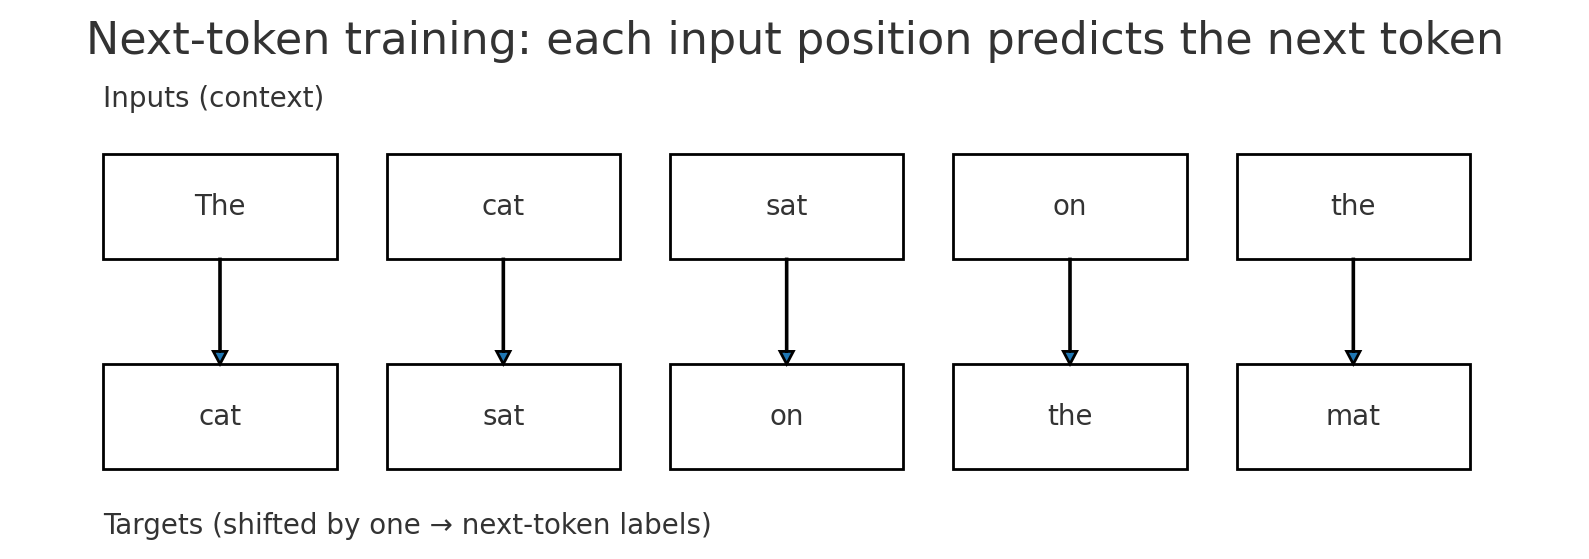




#### **Objection: Isn't this trivial for the first 99?**

No! We make the transformer have *causal attention*. The core thing is that it can only move information forwards in the sequence. The prediction of what comes after token 50 is only a function of the first 50 tokens, *not* of token 51. (Jargon: *autoregressive*)

### **Key takeaway:**

Transformers are *sequence modelling engines*. It does the same processing in parallel at each sequence position, can move information between positions with attention, and conceptually can take a sequence of arbitrary length (not actually true, see later)


<!-- The introduction of a typical Transformer-based classifier, like [BERT](https://arxiv.org/pdf/1810.04805), has to be preceeded by its main components: the MultiHeadAttention, the PositionalEncoding and the FeedForward layers.


### Part II: Decoder-only Transformer Architecture

The decoder-only transformer consists of multiple identical blocks stacked sequentially.
Each block is composed of two main elements:
- A masked multi-head self-attention mechanism.
- A feedforward neural network.

These components are typically encapsulated within residual connections and layer normalization.
In this section, we will explore the intrnal structure of these blocks in greater depth and provide a practical PyTorch implementation.

TODO: edit the figure

![Decoder Only Architecture](https://drive.google.com/uc?id=1ksROxQxf3b7dlBUoIQggzyLeBaPO-AQn) -->

In [ ]:
# @title Step 0: Imports
!pip install datasets torchinfo

from tqdm import tqdm
import math
from collections import Counter
from typing import List, Tuple, Union
import numpy as np


import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers.processors import BertProcessing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



### 📚 Input & Output to transformers
**How do we convert language to vectors?**

ML models take in vectors, not directly texts - how do we convert?

#### **Idea: integers to vectors**

We basically make a lookup table. Called an embedding.

Jargon: **One-hot encoding** We map eg numbers from 1 to 100, to a 100-dim vector, with a 1 in the kth position, 0 everywhere else. Key intuition is that one-hot encodings let you think about each integer independently - useful when integers = labels.

Dimensions = things that vary independently. Each input has its own dimension, so each input can be thought of independently, we don't bake in any relation.

Lookup tables <=> Multiply a fixed matrix by the one-hot encoded vector.


### **Tokens: Language to sequence of integers**

Neural networks work with numbers, not raw text. So the first step is to map text into tokens, each represented by an integer from a fixed vocabulary.

Step 1: Define a Vocabulary

We need a bounded set of tokens that can cover any possible input text.

Naïve Idea 1: Dictionary of words

✅ Intuitive: “language” → one token.

❌ Fails on typos, rare words, URLs, emojis, etc. Vocabulary becomes huge and brittle.

Naïve Idea 2: Characters (e.g., 256 ASCII symbols)

✅ Works on any text, even nonsense strings.

❌ Loses structure: “language” is broken into 8 characters, treated no differently from “hjksdfiu”. Inefficient and less meaningful.

### **What Actually Happens: Subword Tokenization**

Most modern LLMs use Byte-Pair Encoding (BPE) or similar methods.

Start with characters (e.g., all ASCII).

Iteratively merge the most common pairs into new tokens:

e.g. " t" → becomes one token,

"he" → becomes one token,

"language" eventually becomes its own token.

After ~50k merges, we get a rich vocabulary that balances flexibility (can handle any text) with efficiency (common words are single tokens).

Quirks you’ll see in GPT-style tokenizers:

Special marker Ġ means “token begins with a space.”

Example: "Ġcat" (with leading space) is a different token from "cat".

This helps the model represent word boundaries explicitly.

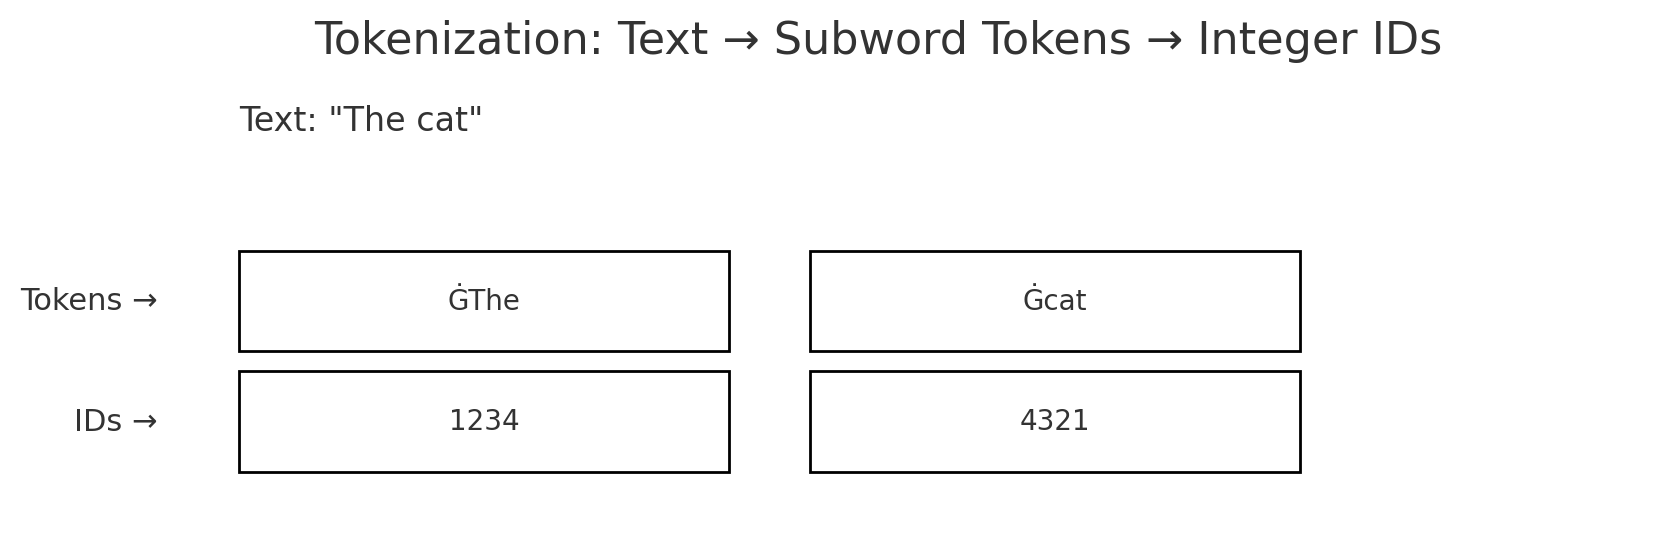

###**Predicting Next Tokens**

Goal: Train the model to produce a probability distribution over the next token at every position in the sequence.

Given n tokens, the model generates n predictions (one for each prefix).
How do we turn a vector of raw scores (logits) into a probability distribution?

Answer: Use a softmax ($x_i \to \frac{e^{x_i}}{\sum e^{x_j}}$), exponential makes everything positive, normalization makes it add to one.

The exponential ensures all outputs are positive.

Normalization ensures the probabilities sum to 1.

###**How the model works:**

The model outputs a tensor of logits of shape (sequence_length, vocab_size).

Each row corresponds to one input token's context and contains a vector over the vocabulary (d_vocab).

Applying softmax to these logits gives a probability distribution for the next token.

# Dataset and Tokenizer

## 📚 Step 1: Load a Dataset

We'll use the HuggingFace datasets library to load a dataset to play with.

In [ ]:
dataset = load_dataset('Trelis/tiny-shakespeare')['train']
texts = [sample["Text"] for sample in dataset]

## 📚 Step 2: Tokenizers Introduction

Neural networks work with numbers, not raw text. To process language, we first cut text into manageable pieces ('tokens') and map each token to an integer ID.
This process is called tokenization.

Four well-known types of tokenization are Character-level, Word-level, BPE and WordPiece, the last two known as two Subword tokenizers:

1. **Character-Level Tokenization:**
    - **Description:** Character-level tokenization breaks down text into individual characters. Each character, including spaces and punctuation, is treated as a separate token. Used in the old days.
    - **Example**: For the sentence "Hello, world!", character-level tokenization would result in tokens: ['H', 'e', 'l', 'l', 'o', ',', ' ', 'w', 'o', 'r', 'l', 'd', '!'].

2. **Word-level Tokenization:**
    - **Description:** Word-level tokenization splits text into words based on whitespace or punctuation. Each word is considered a separate token. Used in the old days.
    - **Example:** For the sentence "Hello, world!", word-level tokenization would result in tokens ['Hello', ',', 'world', '!'].

3. **Byte-Level Byte Pair Encoding (Byte-level BPE):**
    - **Description:** Byte-level BPE tokenization operates on bytes of the input text. It uses a merge operation to gradually build a vocabulary of byte pairs, making it useful for handling multilingual texts and rare characters. Used by e.g. GPT-2, RoBERTa. GPT-3, GPT-NeoX, GPT-J, all use variants of byte-level BPE
    - **Example:** It creates tokens based on byte pairs, such as "b" and "an" merging into a single token "ban".

4. **WordPiece Tokenization:**
    - **Description:** WordPiece tokenization breaks words into smaller units. It begins with a basic vocabulary of individual characters and merges the most frequent character sequences to form new tokens. Used by e.g. BERT, DistilBERT, and Electra.
    - **Example:** For the word "tokenization", WordPiece might create tokens like "token", "##ization" where "##" indicates continuation.

Different tokenizers strike different balances between vocabulary size, efficiency, and ability to handle rare or novel text. In practice, you'll usually rely on the tokenizer shipped with a model (e.g., GPT-2's byte-level BPE, BERT's WordPiece, LLaMA's SentencePiece).

Typically you will end up using an existing tokenizer, for example the one used by GPT-2 is relatively popular, but here we show you the steps to create a new from scratch using the tokenizers library by HuggingFace.

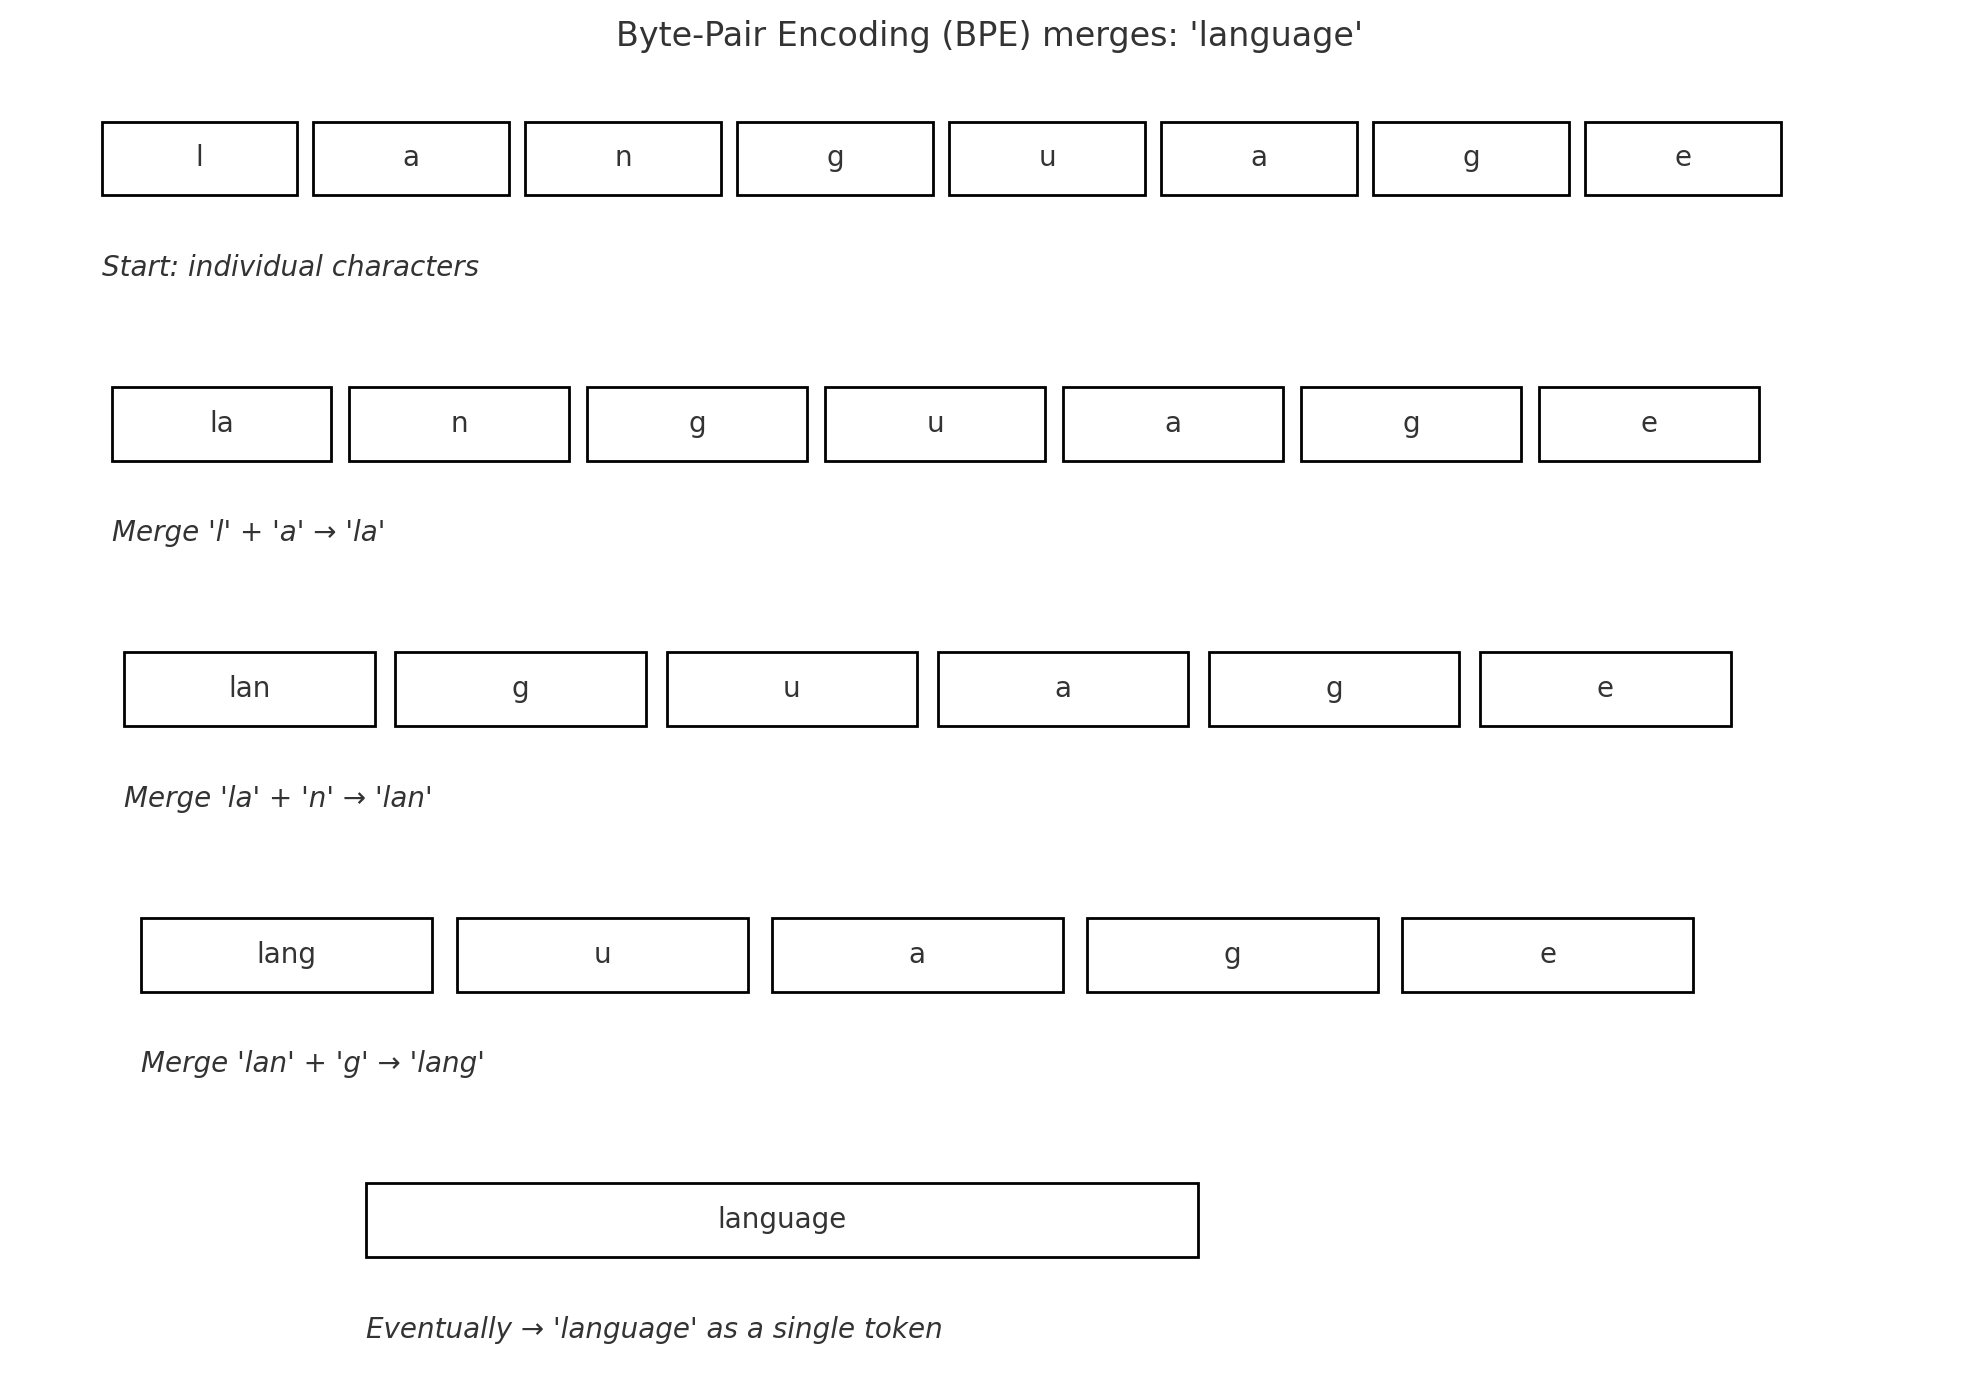

**📚 A comparison of different types of tokenizers**

| Tokenizer Typ |Description | Pros | Cons | Used In|
| ------------------------------ | -------------------------------------------------------------- | ------------------------------------------------------------- | ---------------------------------------------------------- | ------------------------- |
| **Character-level**            | Split text into individual characters                          | Simple, handles any text                                      | Very long sequences, loses word structure                  | Early models, RNN demos   |
| **Word-level**                 | Split on whitespace/punctuation                                | Intuitive, compact for common words                           | Huge vocab, fails on typos/rare words                      | Early NLP pipelines       |
| **Byte-level BPE**             | Start from raw bytes (0–255), iteratively merge frequent pairs | Robust to any text (punctuation, emojis, code), bounded vocab | Tokens can look “weird” (Ġ, ##), merges may be unintuitive | GPT-2, GPT-3, RoBERTa     |
| **WordPiece**                  | Subword units optimized by likelihood                          | Good balance of vocab size vs coverage                        | Still splits rare words into many tokens                   | BERT, DistilBERT, Electra |
| **SentencePiece (Unigram LM)** | Probabilistic model chooses subwords                           | Flexible, language-agnostic, efficient                        | Slightly slower to train                                   | LLaMA, Mistral, T5        |


In [ ]:
# @title ✍ WordPiece Tokenizer Example
# Set the maximal number of integers fed to the Neural Network per sentence
max_length = 128

# Set the number of elements the tokenizer will create as its vocabulary
vocab_size = 30522

# Initialize the tokenizer with a WordPiece model, using "[UNK]" for unknown tokens
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))

# EXERCISE: Configure the tokenizer to split input text based on whitespace, as a .pre_tokenizer
tokenizer.pre_tokenizer = TODO

# Display the dataset to be used for training the tokenizer
train_texts = dataset["Text"]

# EXERCISE: Train the tokenizer
trainer = WordPieceTrainer(vocab_size=vocab_size, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train_from_iterator(TODO

# Set up post-processing to handle padding and truncation as BERT inputs
tokenizer.post_processor = BertProcessing(
    ("SEP", tokenizer.token_to_id("[SEP]")),  # Token to mark the end of a sequence
    ("CLS", tokenizer.token_to_id("[CLS]")),  # Token to mark the beginning of a sentence
)

# EXERCISE: Enable truncation to ensure long sequences do not exceed max_length
tokenizer.enable_TODO

# EXERCISE: Enable padding to ensure short sequences reach the max_length,
# adding the "[PAD]" token at the end of the sequence.
tokenizer.enable_TODO


In [ ]:
# ⚙️ Test the WordPiece Tokenizer

texts = [
    "Hello, how are you?",
    "I am fine, thank you!",
    "What about you?",
    "[MASK][CLS]"
]

response = 'nice'

for text in texts:
    print('-'*89)
    print("Text:  ", text)
    output = tokenizer.encode(text, response)
    print("Tokens:", output.tokens)
    print("IDs:   ", output.ids)
    print("length:", len(output.ids))

## 📚 Step 3: Tokenizer from Scratch

Tokenization is a fundamental preprocessing step in large language models (LLMs). It converts raw text into a sequence of tokens, which are then mapped to integer IDs that neural networks can process.

This step allows us to turn variable-length natural language into a fixed, numerical representation suitable for model input.

In this section, we implement a simple word-level tokenizer. While this is only a starting point, it highlights the key ideas behind more advanced tokenization strategies.

1. Vocabulary management

Instead of keeping all unique words, apply a frequency threshold (e.g., include only words that occur more than N times).

Rare words are replaced with an <UNK> (unknown) token.

This keeps the vocabulary smaller and training more efficient.

2. N-grams or phrase detection

Capture common multi-word phrases (e.g., “New York” or “machine learning”) as single tokens.

Reduces sequence length and helps preserve semantic meaning.

3. Punctuation handling

Current word-level tokenizers treat "word." and "word" as different tokens.

Improvement: normalize punctuation (e.g., strip or split punctuation into its own token).

4. Subword methods (beyond word-level)

Byte-Pair Encoding (BPE), WordPiece, or SentencePiece handle rare words and typos much better.

These are the methods used in modern LLMs (GPT, BERT, LLaMA).

**✨ Additional Resources:**

*  Overview of [Hugging Face tokenizers](https://huggingface.co/docs/transformers/en/tokenizer_summary)

* The Illustrated [Word2vec & Subword Tokenization](https://jalammar.github.io/illustrated-word2vec/) (great visuals)


In [ ]:
class SimpleTokenizer:
    def __init__(self):
        """Initialize the tokenizer with special tokens and prepare vocabulary structures."""
        # Special tokens are used for various purposes in NLP tasks:
        # <PAD>: Used for padding sequences to a fixed length
        # <UNK>: Represents unknown words not in the vocabulary
        # <SOS>: Marks the start of a sequence
        # <EOS>: Marks the end of a sequence
        self.special_tokens = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]

        # word_to_idx: Maps words to uniqie integer indices
        # This is crucial for converting text into a format that neural networks can process
        self.word_to_idx = {token: idx for idx, token in enumerate(self.special_tokens)}

        # idx_to_word: The reverse mapping of word_to_idx
        # This is used for converting model outputs back into readable text
        self.idx_to_word = {idx: token for idx, token in enumerate(self.special_tokens)}

        # Counter object to keep track of word frequencies in the corpus
        self.word_count = Counter()

    def fit(self, texts: List[str]) -> None:
        """Builds the vocabulary from a list of texts."""
        # Count the frequency of each word in the entire corpus
        for text in texts:
            self.word_count.update(text.split())

        # Add each unique word to the vocabulary
        # We assign a unique index to each word, which the model will use to represent words
        for word in self.word_count:
            if word not in self.word_to_idx:
                idx = len(self.word_to_idx)
                self.word_to_idx[word] = idx
                self.idx_to_word[idx] = word

    def encode(self, text:str) -> List[int]:
        """Converts a text string to a list of indices."""
        # This method is used to prepare input for the model
        # It converts each word to its corresponding index
        # If a word is not in the vocabulary, it uses the <UNK> token
        return [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in text.split()]

    def decode(self, indices: List[int]) -> str:
        """Converts a list of indices back to a text string."""
        # This method is used to convert model output back into a readable text
        # It maps each index back to its corresponding model
        return " ".join([self.idx_to_word.get(idx, "<UNK>") for idx in indices])

    def encode_batch(self, texts: List[str]) -> List[List[int]]:
        """Converts a batch of text strings to lists of indices."""
        return [self.encode(text) for text in texts]

    def decode_batch(self, batch_indices: List[List[int]]) -> List[str]:
        """Converts a batch of lists of indices back to text strings."""
        return [self.decode(indices) for indices in batch_indices]

    def show_vocab(self):
        """Display the vocabulary."""
        # Useful for debugging and understanding the tokenizer's state
        print("Vocabulary:")
        for word, idx in self.word_to_idx.items():
            print(f"{word}: {idx}")

    def __len__(self):
        """Return the size of the vocabulary."""
        # The vocabulary size is an important parameter for the model
        # It determines the dimensionality of the model's output layer
        return len(self.word_to_idx)

### ⚙️ Tokenizer Test


In [ ]:
## @title ⚙️ Tokenizer Test
# This testing function shows examples of text tokenization presenting also extreme use cases.

def test_tokenizer():
    print("Testing SimpleTokenizer")
    print("=" * 89)

    # Sample texts
    texts = [
        "The quick brown fox jumps over the lazy dog.",
        "Pack my box with five dozen liquor jugs!",
        "How vexingly quick daft zebras jump!",
        "This is a sentence with some punctuation, including commas.",
        "This text contains an unknown word: monkey",
        ""  # Empty string to test edge case
    ]

    # Initialize and fit the tokenizer
    tokenizer = SimpleTokenizer()
    tokenizer.fit(texts)

    # Display vocabulary
    print(f"Vocabulary size: {len(tokenizer)}")
    print("=" * 89)

    # Test encoding and decoding
    print("Encoding and Decoding Test:\n")
    for text in texts:
        encoded = tokenizer.encode(text)
        decoded = tokenizer.decode(encoded)
        print(f"Original: {text}")
        print(f"Encoded : {encoded}")
        print(f"Decoded : {decoded}")
        print(f"Match   : {'✓' if text.strip().lower() == decoded.strip().lower() else '✗'}")
        print("-" * 30)
    print("="*89)

    # Test unknown word handling
    print("Unknown Word Handling Test:")
    unknown_text = "This text contains and unknown word: xylophone"
    encoded_unknown = tokenizer.encode(unknown_text)
    decoded_unknown = tokenizer.decode(encoded_unknown)
    print(f"Original: {unknown_text}")
    print(f"Encoded : {encoded_unknown}")
    print(f"Decoded : {decoded_unknown}")
    print("=" * 89)

    # Test special tokens
    print("Special Tokens Test:")
    special_text = "<SOS> This is a test sentence <EOS>"
    encoded_special = tokenizer.encode(special_text)
    decoded_special = tokenizer.decode(encoded_special)
    print(f"Original: {special_text}")
    print(f"Encoded : {encoded_special}")
    print(f"Decoded : {decoded_special}")
    print("=" * 89)

    # Test case sensitivity
    print("Case Sensitivity Test:")
    case_text = "The Quick Brown Fox"
    encoded_case = tokenizer.encode(case_text)
    decoded_case = tokenizer.decode(encoded_case)
    print(f"Original: {case_text}")
    print(f"Encoded : {encoded_case}")
    print(f"Decoded : {decoded_case}")
    print("=" * 89)

test_tokenizer()

## 📚 Step 4: TextDataset: Efficient Text Processing

When training language models, we need a way to turn long, raw text streams into fixed-length chunks of tokens that can be fed to a neural network. A TextDataset (either a custom PyTorch Dataset class or a preprocessing pipeline) is often used for this.

The key idea is to use a sliding window (or fixed-block) approach:

* Long texts are split into overlapping or consecutive token sequences of length N.

* Each sequence serves as one training example, allowing the model to learn next-token prediction efficiently while preserving local context.

A well-designed TextDataset bridges the gap between raw text and model-ready input by handling:

* **Tokenization** → convert text into integer IDs.

* **Chunking / sliding windows** → break long streams into manageable segments.

* **Padding & truncation** → ensure uniform sequence lengths within a batch.

* **Attention masks** → tell the model which positions are real tokens vs. padding.

These steps are essential for training Transformers, which require batched, fixed-shape tensors.

[Hugging Face Padding and truncation](https://huggingface.co/docs/transformers/en/pad_truncation)

**Note:** Hugging Face used to provide a TextDataset utility in transformers, but it's now deprecated. The recommended approach is to use the [datasets library](https://huggingface.co/docs/datasets/index) (load_dataset) and then wrap your tokenized data in a PyTorch Dataset or DataLoader.

<!-- The TextDataset class is a crucial component in preparing text data for deep learning models, implementing a sliding window approach that allows processing of variable-length texts while maintaining context.

This class bridges the gap between raw text data and the input requirements of neural networks, handling tasks such as tokenization, padding, and attention mask generation, which are essential for training effective sequence models like Transformers.

**✨ Additional Resources:**

* [Hugging Face Padding and truncation](https://huggingface.co/docs/transformers/en/pad_truncation) -->

In [ ]:
class TextDataset(Dataset):
    def __init__(
            self,
            texts: List[str],
            tokenizer: SimpleTokenizer,
            max_length:int,
            overlap: int = 50,
    ):
        """
        Initialize the TextDataset with sliding window functionality.

        Args:
            texts (List[str]): List of input texts.
            tokenizer (SimpleTokenizer): Tokenizer object for encoding texts.
            max_length (int): Maxmimum length of encoded sequences.
            overlap (int): Number of overlapping tokens between windows.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.overlap = overlap
        self.data = []
        self.attention_mask = []
        self.windowidx2docidx = []  # Maps each window to its original document
        self.original_texts = texts  # Store original texts

        for doc_idx, text in enumerate(texts):
            tokens = self.tokenizer.encode(text)
            windows = self.create_sliding_windows(tokens)

            for window in windows:
                attention_mask = [1] * len(window)  # 1 for real tokens

                # Pad if necessary
                if len(window) < max_length:
                    padding_length = max_length - len(window)
                    window = window + [self.tokenizer.word_to_idx["<PAD>"]] * padding_length
                    attention_mask = attention_mask + [0] * padding_length

                self.data.append(window)
                self.attention_mask.append(attention_mask)
                self.windowidx2docidx.append(doc_idx)

    def create_sliding_windows(self, tokens: List[int]) -> List[List[int]]:
        """
        Create sliding windows from a list of tokens.

        Args:
            tokens (List[int]): List of encoded tokens.

        Returns:
            List[List[int]]: List of sliding windows.
        """
        windows = []
        # Calculate stride: how many tokens to move for each new window
        # -1 accounts for the added <SOS> token at the start of each window
        stride = self.max_length - self.overlap - 1

        for start in range(0, len(tokens), stride):
            # Create a window starting with <SOS> token
            window = [self.tokenizer.word_to_idx["<SOS>"]] + tokens[start:start+self.max_length-1]
            if len(window) < self.max_length:
                # This is the last window, add <EOS> token
                window.append(self.tokenizer.word_to_idx["<EOS>"])
            windows.append(window)
        return windows

    def get_original_document(self, doc_idx: int) -> str:
        """Retrieve the original document text."""
        if 0 <= doc_idx < len(self.original_texts):
            return self.original_texts[doc_idx]
        else:
            raise IndexError(f"Document index {doc_idx} out of range")

    def get_document_length(self, doc_idx: int) -> int:
        """Get the number of tokens in the original document."""
        if 0 <= doc_idx < len(self.original_texts):
            return len(self.tokenizer.encode(self.original_texts[doc_idx]))
        else:
            raise IndexError(f"Document index {doc_idx} is out of range")

    def window_to_document_position(self, window_idx: int, token_idx: int) -> Tuple[int, int]:
        """Map a position in a window back to its position in the original document."""
        if 0 <= window_idx < len(self.data):
            doc_idx = self.windowidx2docidx[window_idx]
            doc_windows = self.get_document_windows(doc_idx)
            # Find which window of the document this is
            relative_window_idx = doc_windows.index(window_idx)
            # Calculate the start position of this window in the document
            window_start = relative_window_idx * (self.max_length - self.overlap - 1)
            # -1 to account for <SOS> token at the start of each window
            return doc_idx, window_start + token_idx - 1
        else:
            raise IndexError(f"Window index {window_idx} is out of range.")


    def __len__(self) -> int:
        """Get the number of windows in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        """
        Get a sample from the dataset.

        Args:
            idx (int): Index of the sample.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, int]:
                A tuple containing (token_ids, attention_mask, document_index).
        """
        if 0 <= idx < len(self.data):
            # Add an extra dimension to make it batch-first (batch_size=1)
            return (
                torch.tensor(self.data[idx]).unsqueeze(0),
                torch.tensor(self.attention_mask[idx]).unsqueeze(0),
                self.windowidx2docidx[idx]
            )
        else:
            raise IndexError(f"Index {idx} is out of range.")

    def get_document_window_indices(self, doc_idx: int) -> List[int]:
        """
        Get all window indices for a specific document.

        Args:
            doc_idx (int): Index of the document.

        Returns:
            List[int]: List of window indices for the document.
        """
        return [w_idx for w_idx, d_idx in enumerate(self.windowidx2docidx) if d_idx == doc_idx]



### ⚙️ Test the TextDataset class

In [ ]:
## @title ⚙️ TextDataset Test
# This testing function shows how the TextDataset and SimpleTokenizer classes work together.

def test_sliding_window_dataset():
    print("--- Testing Sliding Window Dataset ---")
    print("="*89)

    texts = [
        "This is a short sentence.",
        "This is a much longer sentence that will be split into multiple windows to demonstrate the sliding window approach. It contains enough tokens to create at least two or three windows depending on the chosen maximum length and overlap.",
        "Another sentence of medium length that might create two windows.",
        "",  # Empty text to test edge case
        "Short."  # Very short text to test edge case
    ]

    try:
        tokenizer = SimpleTokenizer()
        tokenizer.fit(texts)

        max_length = 16
        overlap = 5
        dataset = TextDataset(texts, tokenizer, max_length, overlap)

        print(f"Dataset configuration:")
        print(f"  Max length: {max_length}")
        print(f"  Overlap: {overlap}")
        print(f"  Total windows: {len(dataset)}")
        print(f"  Vocabulary size: {len(tokenizer)}")
        print("-"*30)

        for doc_idx, text in enumerate(texts):
            print(f"Document {doc_idx}:")
            print(f"  Original text: '{text}'")
            print(f"  Number of words: {len(text.split())}")
            print(f"  Number of tokens: {len(tokenizer.encode(text))}")

            window_indices = dataset.get_document_window_indices(doc_idx)
            print(f"  Number of windows: {len(window_indices)}")
            print()

            for i, window_idx in enumerate(window_indices):
                tokens, attention_mask, _ = dataset[window_idx]
                # Remove the batch dimension for decoding
                decoded = tokenizer.decode(tokens.squeeze().tolist())
                print(f"  Window {i}:")
                print(f"    Window index: {window_idx}")
                print(f"    Tokens shape: {tokens.shape}")
                print(f"    Tokens: {tokens.squeeze().tolist()}")
                print(f"    Attention mask shape: {attention_mask.shape}")
                print(f"    Attention mask: {attention_mask.squeeze().tolist()}")
                print(f"    Decoded: '{decoded}'")
                print(f"    Window length: {tokens.size(1)}")
            print("-"*30)
        print("="*89)

        tokenizer.show_vocab()

    except Exception as e:
        print(f"An error occurred: {str(e)}")

    print()
    print("--- End of Test ---")

test_sliding_window_dataset()


# Transformer Components

## ✍ Step 1: Positional Encoding

Positional Encoding adds information about the position of each token in the sequence.
This is necessary because the self-attention mechansim in Transformers doesn't inherently have a notion of token order.

\begin{equation}
PE_{(pos, 2i)} = \sin\left( \frac{pos}{10000^\frac{2i}{d_{model}}} \right)
\end{equation}

\begin{equation}
PE_{(pos, 2i+1)} = \cos\left( \frac{pos}{10000^\frac{2i}{d_{model}}} \right)
\end{equation}

To give the model positional information, we add a positional encoding to each token embedding. This allows the Transformer to distinguish between, for example, "cat sat on" vs. "on sat cat".

**✨ Additional resources:**
* [Transformer Architecture: The Positional Encoding](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)

* [Positional Encoding in Transformers](https://www.geeksforgeeks.org/positional-encoding-in-transformers/)

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [max_len, d_model] representing the positional encoding for max_len inputs
        pe = TODO

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Compute the `div_term` for the fequency component using the formual involving d_model
        div_term = TODO

        # Populate the even indices (0, 2, 4, ...) of `pe` with the sine of the position multiplied by the `div_term`
        pe[:, 0::2] = TODO

        # Populate the odd indices (1, 3, 5, ...) of `pe` with the cosine of the position multiplied by the `div_term`
        pe[:, 1::2] = TODO

        # Add an **extra dimension** to `pe` to act as batch dimension
        pe = TODO

        # Register `pe` as a bufer to ensure it is not considered a model parameter but is moved to appropriate model device
        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTroch not to add the buffer to the state dict (e.g. when we save the model)
        self.TODO

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


### ⚙️ PosEnc Test

In [ ]:
## @title ⚙️ PosEnc Test
def test_positional_encoding_consistency():
    # Test parameters
    d_model = 4
    max_len = 10
    batch_size = 2
    seq_len = 3

    # Initialize a new PositionalEncoding module each time
    pe = PositionalEncoding(d_model, max_len)

    # Create a small input tensor
    x1 = torch.zeros(batch_size, seq_len, d_model)

    # Run the positional encoding
    output = pe(x1)

    print("Input:")
    print(x1)
    print("\nOutput:")
    print(output)

    print("""\nNote: If your
    Output:
        tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
                [ 0.8415,  0.5403,  0.0100,  0.9999],
                [ 0.9093, -0.4161,  0.0200,  0.9998]],

                [[ 0.0000,  1.0000,  0.0000,  1.0000],
                [ 0.8415,  0.5403,  0.0100,  0.9999],
                [ 0.9093, -0.4161,  0.0200,  0.9998]]])
             , the PositionalEncoding is consistent.""")

test_positional_encoding_consistency()

In [ ]:
def test_positional_encoding_with_dataset():
    print("--- Testing Positional Encoding with Dataset ---")

    # Set a fixed seed for reproducibility
    torch.manual_seed(42)

    # Sample texts
    texts = [
        "This is a short sentence.",
        "This is a much longer sentence that will be split into multiple windows. Observe the term overlapping?",
        "Another sentence of medium length."
    ]

    # Initialize tokenizer and fit it to the texts
    tokenizer = SimpleTokenizer()
    tokenizer.fit(texts)

    # Create a dataset with the tokenizer
    max_length = 10
    overlap = 2
    dataset = TextDataset(texts, tokenizer, max_length, overlap)

    # Create dataset
    max_length = 10
    overlap = 2
    dataset = TextDataset(texts, tokenizer, max_length, overlap)

    # Initialize positional encoding
    d_model = 16  # Small dimension for demonstration
    pos_encoder = PositionalEncoding(d_model, max_length)

    print(f"Dataset configuration:")
    print(f"  Max length: {max_length}")
    print(f"  Overlap: {overlap}")
    print(f"  Total windows: {len(dataset)}")
    print(f"  Vocabulary size: {len(tokenizer)}")
    print(f"  Embedding dimesions: {d_model}")
    print("-"*30)

    # Process each window through the positional encoding
    for i in range(len(dataset)):
        tokens, attention_mask, doc_idx = dataset[i]

        # Convert tokens to "embeddings" (just for demonstration)
        pseudo_embeddings = torch.rand(1, tokens.size(1), d_model)  # (batch_size, seq_len, d_model)

        # Apply positional encoding
        encoded = pos_encoder(pseudo_embeddings)

        print(f"Window {i} (from document {doc_idx}):")
        print(f"  Original tokens: {tokens.squeeze(0).tolist()}")
        print(f"  Attention mask: {attention_mask.squeeze(0).tolist()}")
        print(f"  Decoded: '{tokenizer.decode(tokens.squeeze(0).tolist())}'")
        print(f"  Shape after positional encoding: {encoded.shape}")

        # Display the positional encoding effect for all tokens
        print(f"  Positional Encoding Effect:")
        for j in range(tokens.size(1)):
            if attention_mask[0, j] == 1:  # Only display for real tokens
                print(f"    Token {j}:")
                print(f"      Original embedding: {pseudo_embeddings[0, j, :].tolist()}")
                print(f"      Encoded embedding : {encoded[0, j, :].tolist()}")
        print("-"*30)

    # print("="*89)
    print("--- End of Test ---")

test_positional_encoding_with_dataset()


## ✍ Step 2: MultiHeadAttention (MHA)

The key to the MultiHeadAttention mechanism is the softmax attention.
The attention scores are computed using the scaled dot-product of the Query and Key vectors:

$$
\text{Attention}(Q, K, V) =
\text{softmax}
    \Big(
        \frac{QK^T}{\sqrt{d_k}}
    \Big)
    V
$$

where:
+ $Q, K, V$ are the "query", "key" and "value" vectors respectively. These are typically linear projections of the same tensor (through different weights).
+ $d_k$ is the dimensionality of the $Q, K, V$ vectors. In the case of a "multi-head" attention, this correponds to dimensionality of a single "head" vector ($d_{head}$).
+ The `softmax` operation ensures that the scores are normalized and mapped through a non-linearity, which increases NN's expressivity (side note: there exist [Transfomer version with Linear Attention](https://arxiv.org/abs/2006.16236), that are faster, but also less powerful).
+ $\sqrt{d_k}$ is the scaling factor that helps mitigate the issue of large dot-product values.

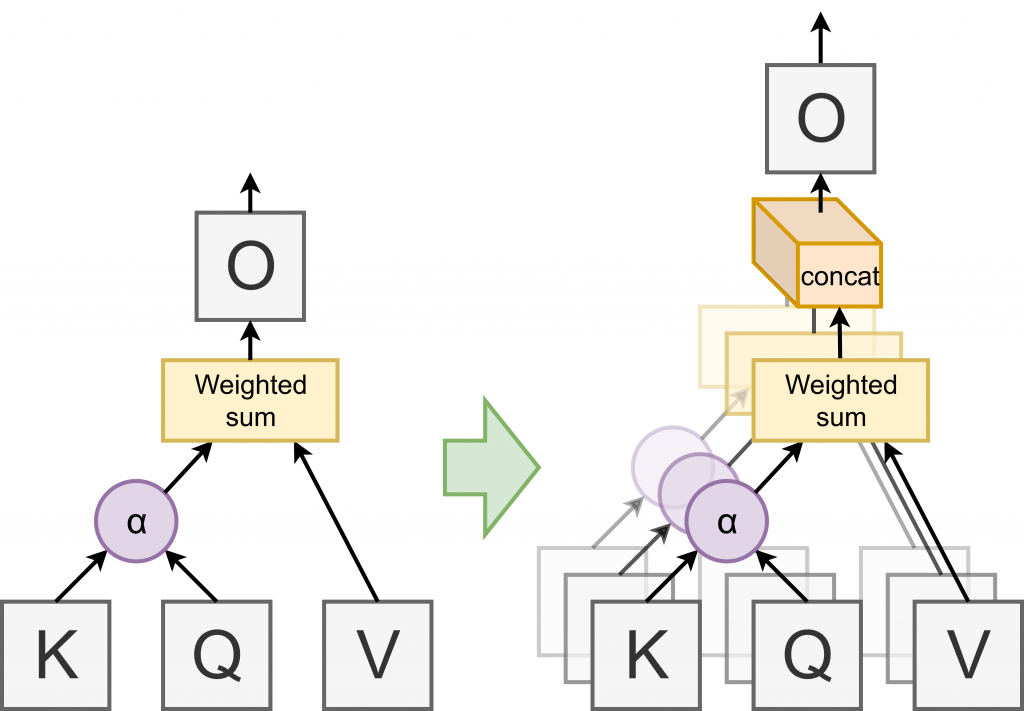

Reference: [Are Sixteen Heads Really Better than One?
](https://blog.ml.cmu.edu/2020/03/20/are-sixteen-heads-really-better-than-one/)

In [ ]:
# Multi-head Attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        # EXERCISE: create the following 4 linear layers
        self.linear_q = TODO
        self.linear_k = TODO
        self.linear_v = TODO
        self.linear_out = TODO

    def forward(self, query, mask=None):
        batch_size = query.size(0)

        # Linear projections
        Q = self.linear_q(query)
        K = self.linear_k(query)
        V = self.linear_v(query)

        # Split into multiple heads
        Q = Q.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_head)
        K = K.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_head)
        V = V.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_head)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch_size, n_heads, seq_len, seq_len)

        # EXERCISE: divide the scores by the normalizing factor
        scores = TODO

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1)  # (batch_size, 1, 1, seq_len)
            scores = scores.masked_fill(mask == 0, -1e9)

        # Attention weights
        # EXERCISE: apply the softmax to the scores to have the attn_weights
        attn_weights = TODO

        # Weighted sum of values
        attn_output = torch.matmul(attn_weights, V)  # (batch_size, n_heads, seq_len, d_head)

        # Concatenate heads and project back to d_model
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)  # (batch_size, seq_len, d_model)

        attn_output = TODO

        return attn_output


## ✍ Step 3: Masked MHA Layer

You have implemented the Attention Mechanism for learning purposes and to know what the key components of MHA are.
Here, you will use PyTorch's native implementation.

Masked Attention allows the Transformer to focus on relevant parts of the input sequence, while preventing information leakage from future tokens during (why we used the term "masked").

Please visit [this link](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) for a detailed description of PyTorch's MHA function.

**✨ Additional Resources:**

* [Multi-head Attention, deep dive](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)
* [Attention Is All You Need (original Transformer paper)](https://arxiv.org/abs/1706.03762)

* [A visual explanation of the attention mechanism](https://www.youtube.com/watch?v=bCz4OMemCcA&t=1208s&ab_channel=UmarJamil)

In [ ]:
class MaskedAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float=0.1):
        super().__init__()
        #######################Code Here###############################
        # Initialize the MultiheadAttention layer using PyTorch's native
        # implementation `nn.MultiheadAttention` (NOT the above "MHA from scratch" implementation).
        # Use the provided dropout parameter, and set the `batch_first` argument
        # of the MHA module to True.
        # TODO
        ###############################################################

    def generate_square_subsequent_mask(self, sz: int) -> torch.Tensor:

        #######################Code Here###############################
        # Create a triangular mask tensor in PyTorch where the lower triangle
        # (including the diagonal) is filled with ones and the upper triangle
        # is filled with zeros. The tensor should be of size (sz, sz).
        # TODO
        ###############################################################
        # The masked positions are filled with float('-inf').
        # Unmasked positions are filled with float(0.0)
        # See: https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#Transformer
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        seq_len = x.size(1)
        attn_mask = self.generate_square_subsequent_mask(seq_len).to(x.device)
        output, _ = self.multihead_attn(x, x, x, attn_mask=attn_mask)
        return output, attn_mask


### ⚙️ Testing the MHA

In [ ]:
## @title ⚙️ Testing the MHA
def test_multihead_attention():
    print('--- Testing MultiHead Attention ---')

    # Set a fixed seed for reproducibility
    torch.manual_seed(42)

    # Sample texts
    texts = [
        "This is a short sentence.",
        "This is a much longer sentence that will be split into multiple windows. Observe the term overlapping?",
        "Another sentence of medium length."
    ]

    # Initialize tokenizer and fit it to the texts
    tokenizer = SimpleTokenizer()
    tokenizer.fit(texts)

    # Create dataset
    max_length = 10
    overlap = 2
    dataset = TextDataset(texts, tokenizer, max_length, overlap)

    # Hyperparameters
    d_model = 16
    n_heads = 2

    # Initialize components
    pos_encoder = PositionalEncoding(d_model, max_length)
    masked_self_attn = MaskedAttention(d_model, n_heads)

    print(f"Dataset configuration:")
    print(f"  Max length: {max_length}")
    print(f"  Overlap: {overlap}")
    print(f"  Total windows: {len(dataset)}")
    print(f"  Vocabulary size: {len(tokenizer)}")
    print(f"  Embedding dimension: {d_model}")
    print(f"  Number of attention heads: {n_heads}\n")

    # Process each window
    for i in range(len(dataset)):
        tokens, attention_mask, doc_idx = dataset[i]

        print(f"Window {i} (from document {doc_idx}):")
        print(f"  Original tokens: {tokens.squeeze(0).tolist()}")
        print(f"  Attention mask: {attention_mask.squeeze(0).tolist()}")
        print(f"  Decoded: '{tokenizer.decode(tokens.squeeze(0).tolist())}'")

        # Convert tokens to "embeddings" (just for demonstration)
        pseudo_embeddings = torch.rand(1, tokens.size(1), d_model)  # (batch_size, seq_len, d_model)
        print(f"  Shape of pseudo embeddings: {pseudo_embeddings.shape}")

        # Apply positional encoding
        pos_encodings = pos_encoder(pseudo_embeddings)
        print(f"  Shape after positional encoding: {pos_encodings.shape}")

        # Apply masked self-attention
        attn_output, attn_mask = masked_self_attn(pos_encodings)
        print(f"  Shape after masked self-attention: {attn_output.shape}")

        # Display the effect of positional encoding and attention for all tokens
        print(f"  Transformer effect on tokens:")
        for j in range(tokens.size(1)):
            if attention_mask[0, j] == 1:  # Only show for non-padding tokens
                print(f"    Token {j}:")
                print(f"      Initial:   {pseudo_embeddings[0, j, :5].tolist()}")
                print(f"      Positional:{pos_encodings[0, j, :5].tolist()}")
                print(f"      Attention Mask: {attn_mask[j, :5].tolist()}")  # Show first 5 values of attention mask
                print(f"      Attention: {attn_output[0, j, :5].tolist()}")
        print()

    print("--- End of Expanded Test ---")

# Run the expanded test
test_multihead_attention()


## ✍ Step 4: FeedForward (FF) Network

A FeedForward Network is a multi-layered network in which information moves in a single direction (no recursion), from the input to the output layer.

**✨ Additional Resources:**

* [Transformer Feed-Forward Layers Are Key-Value Memories](https://arxiv.org/abs/2012.14913)


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()

        #######################Code Here###############################
        # Define FeedForward network using nn.Sequential
        self.net = nn.Sequential(
            # TODO
            # First linear layer
            # ReLU activation
            # Dropout
            # Second linear layer
        )
        ###############################################################

    def forward(self, x):
        return self.net(x)


### ⚙️ Testing FF Network

In [ ]:
## @title ⚙️ Testing FF Network
def test_all_transformer_components():
    print("\n--- Testing Transformer Components ---\n")

    # Set a fixed seed for reproducibility
    torch.manual_seed(42)

    # Sample texts
    texts = [
        "This is a short sentence.",
        "This is a much longer sentence that will be split into multiple windows. Observe the term overlapping?",
        "Another sentence of medium length."
    ]

    # Initialize tokenizer and fit it to the texts
    tokenizer = SimpleTokenizer()
    tokenizer.fit(texts)

    # Create dataset
    max_length = 10
    overlap = 2
    dataset = TextDataset(texts, tokenizer, max_length, overlap)

    # Hyperparameters
    d_model = 16  # Small dimension for demonstration
    n_heads = 2
    d_ff = d_model  # Feed-forward dimension
    dropout = 0.1

    # Initialize components
    pos_encoder = PositionalEncoding(d_model, max_length)
    masked_self_attn = MaskedAttention(d_model, n_heads)
    feed_forward = FeedForward(d_model, d_ff, dropout)

    print(f"Dataset configuration:")
    print(f"  Max length: {max_length}")
    print(f"  Overlap: {overlap}")
    print(f"  Total windows: {len(dataset)}")
    print(f"  Vocabulary size: {len(tokenizer)}")
    print(f"  Embedding dimension: {d_model}")
    print(f"  Number of attention heads: {n_heads}")
    print(f"  Feed-forward dimension: {d_ff}\n")

    # Process each window
    for i in range(len(dataset)):
        tokens, attention_mask, doc_idx = dataset[i]

        print(f"Window {i} (from document {doc_idx}):")
        print(f"  Original tokens: {tokens.squeeze(0).tolist()}")
        print(f"  Attention mask: {attention_mask.squeeze(0).tolist()}")
        print(f"  Decoded: '{tokenizer.decode(tokens.squeeze(0).tolist())}'")

        # Convert tokens to "embeddings" (just for demonstration)
        pseudo_embeddings = torch.rand(1, tokens.size(1), d_model)  # (batch_size, seq_len, d_model)
        print(f"  Shape of pseudo embeddings: {pseudo_embeddings.shape}")

        # Apply positional encoding
        pos_encoded = pos_encoder(pseudo_embeddings)
        print(f"  Shape after positional encoding: {pos_encoded.shape}")

        # Apply masked self-attention
        attn_output, attn_mask = masked_self_attn(pos_encoded)
        print(f"  Shape after masked self-attention: {attn_output.shape}")

        # Apply feed-forward network
        ff_output = feed_forward(attn_output)
        print(f"  Shape after feed-forward: {ff_output.shape}")

        # Display the effect of positional encoding, attention, and feed-forward for all tokens
        print(f"  Transformer effect on tokens:")
        for j in range(tokens.size(1)):
            if attention_mask[0, j] == 1:  # Only show for non-padding tokens
                print(f"    Token {j}:")
                print(f"      Initial:   {pseudo_embeddings[0, j, :5].tolist()}")
                print(f"      Positional:{pos_encoded[0, j, :5].tolist()}")
                print(f"      Attention Mask: {attn_mask[j, :5].tolist()}")  # Show first 5 values
                print(f"      Attention: {attn_output[0, j, :5].tolist()}")
                print(f"      Feed-Forward: {ff_output[0, j, :5].tolist()}")
        print()

    print("--- End of Expanded Test ---")

# Run the expanded test
test_all_transformer_components()

## ✍ Step 5: Decoder Layer

Implementation of a Transformer Decoder Layer with Masked MHA and FF networks.

![Decoder Only Architecture](https://drive.google.com/uc?id=1ksROxQxf3b7dlBUoIQggzyLeBaPO-AQn)


In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)

        #######################Code Here###############################
        # Define the decoder - Layer Normalization, Attention, Feed_forward Dropouts
        # TODO
        ###############################################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Masked self-attention
        normed_x = self.norm1(x)
        attn_output, _ = self.masked_attention(normed_x)

        #######################Code Here###############################
        # Create the remaining connection and residual connections -
        # What is a residual connection? (https://towardsdatascience.com/what-is-residual-connection-efb07cab0d55)
        # TODO
        ###############################################################

        return x


# Transformer Neural Network

## 📚 Step 1: Decoder-only Transformer

The components of a Decoder-only Transformer include;
1. an embedding layer for token representation,
2. positional encoding for sequential information,
3. stacked decoder layers for hierarchical processing,
4. layer normalization for stability,
5. an output projection layer for generating tokens

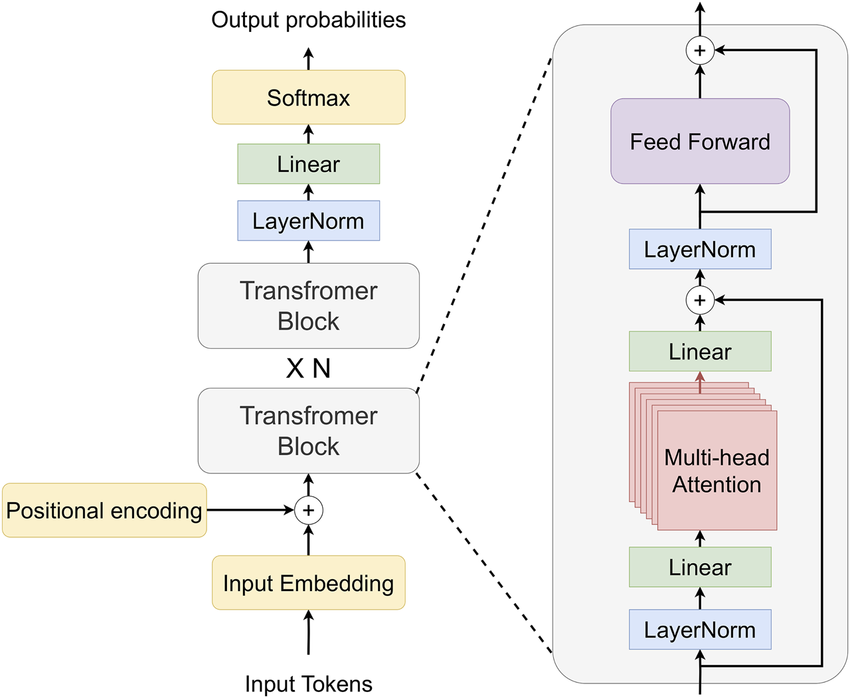


In [ ]:
class DecoderOnlyTransformer(nn.Module):
    def __init__(
            self,
            vocab_size: int,
            d_model: int,
            n_heads: int,
            n_layers: int,
            d_ff: int,
            max_seq_length: int,
            dropout: float=0.1
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_length = max_seq_length

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)
        ])

        # Final layer norm
        self.final_norm = nn.LayerNorm(d_model)

        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, seq_len)

        # Embed the input
        x = self.embedding(x) * math.sqrt(self.d_model)

        # Add positional encoding
        x = self.positional_encoding(x)

        # Apply decoder layers
        for layer in self.layers:
            x = layer(x)

        # Apply final layer norm
        x = self.final_norm(x)

        # Project to vocabulary size
        output = self.output_projection(x)

        return output

    def generate(
            self,
            start_tokens: torch.Tensor,
            max_length: int,
            temperature: float=1.0,
    ) -> torch.Tensor:
        self.eval()
        current_seq = start_tokens

        with torch.no_grad():
            for _ in range(max_length - start_tokens.size(1)):
                # Ensure we're not exceeding the maximum sequence length
                if current_seq.size(1) > self.max_seq_length:
                    current_seq = current_seq[:, -self.max_seq_length:]

                # Get model predictions
                logits = self.forward(current_seq)
                next_token_logits = logits[:, -1, :] / temperature

                # Sample next token
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)

                # Append next token to sequence
                current_seq = torch.cat([current_seq, next_token], dim=1)

                # Check if we've generated an EOS token
                if next_token.item() == self.vocab_size - 1:
                    # Assuming EOS is the last token
                    break
        return current_seq



In [ ]:
# @title ⚙️ Display Architecture
# Initialize the model with some example parameters
vocab_size = 10_000
d_model = 512
n_heads = 2
n_layers = 1
d_ff = 2048
max_seq_length = 1024
dropout = 0.1

# Define your model
model = DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    d_ff=d_ff,
    max_seq_length=max_seq_length,
    dropout=dropout,
)

# Print model summary
summary(model, input_size=(1, max_seq_length), dtypes=[torch.int64])

## 📚 Step 2: Metrics

## 1. **Perplexity (PPL)**
- **Definition**:  $$\text{PPL} = e^{\text{CrossEntropyLoss}}$$
- **Meaning**: Measures how "surprised" the model is by the correct sequence.  
- **Interpretation**:  
  - **PPL = 1** → perfect predictions.  
  - **PPL = 100** → model behaves like there are ~100 equally likely options.  
- **Pros**:
  - Standard in language modeling.
  - Directly related to data likelihood.
- **Cons**:
  - Hard to interpret beyond “lower is better”.
  - Can hide poor predictions on rare words.

## 2. **Cross-Entropy Loss**
- **Definition**: $$\text{Loss} = -\frac{1}{N} \sum_{i=1}^N \log P(y_i \mid \text{context})$$
- **Meaning**: Average negative log probability of the correct token.  
- **Pros**:
  - Directly optimized during training.
  - Basis for calculating perplexity.
- **Cons**:
  - Not scale-invariant (depends on vocabulary size).

## 3. **Token-Level Accuracy**
- **Definition**:  $$\text{Accuracy} = \frac{\text{# correct tokens}}{\text{# total tokens (ignoring padding)}}$$
- **Meaning**: How often the model’s top prediction matches the target token.  
- **Pros**:
  - Easy to understand.
  - Good quick sanity check.
- **Cons**:
  - Doesn’t account for “close” predictions.
  - Can be misleading with large vocabularies.

##4. **Precision, Recall, F1 Score**
- **Definitions**:
  - **Precision**:  
    $$\frac{\text{True Positives}}{\text{True Positives + False Positives}}$$
  - **Recall**:  
    $$\frac{\text{True Positives}}{\text{True Positives + False Negatives}}$$
  - **F1 Score**:
  $$ 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}}$$
- **Meaning**: Measures correctness (**precision**) and completeness (**recall**) together.  
- **Pros**:
  - More detailed than accuracy for imbalanced datasets.
  - Common in structured generation tasks.
- **Cons**:
  - Still token-level; ignores sentence-level meaning.

## 5. **BLEU / ROUGE / METEOR**
- **Meaning**: Compare generated text to reference text using **n-gram overlap**.  
- **Pros**:
  - Common in machine translation and summarization.
  - Captures phrase-level similarity.
- **Cons**:
  - Penalizes valid paraphrases.
  - Not ideal for open-ended generation.

---


In [ ]:
import math
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_perplexity(loss: float) -> float:
    """Convert cross-entropy loss to perplexity."""
    try:
        return math.exp(loss)
    except OverflowError:
        return float('inf')

def calculate_accuracy(logits: torch.Tensor, targets: torch.Tensor, pad_idx: int) -> float:
    """
    Compute token-level accuracy, ignoring padding tokens.

    Args:
        logits: (N, vocab_size) tensor of predicted logits
        targets: (N,) tensor of target token IDs
        pad_idx: index of the <PAD> token
    """
    preds = logits.argmax(dim=-1)
    mask = targets != pad_idx
    correct = (preds == targets) & mask
    return correct.sum().item() / mask.sum().item()

def calculate_precision_recall_f1(logits: torch.Tensor, targets: torch.Tensor, pad_idx: int):
    """
    Compute macro-averaged precision, recall, and F1, ignoring padding.
    """
    preds = logits.argmax(dim=-1).cpu().numpy()
    targets = targets.cpu().numpy()

    mask = targets != pad_idx
    preds = preds[mask]
    targets = targets[mask]

    precision = precision_score(targets, preds, average='macro', zero_division=0)
    recall = recall_score(targets, preds, average='macro', zero_division=0)
    f1 = f1_score(targets, preds, average='macro', zero_division=0)

    return precision, recall, f1


## 📚 Step 3: Training the Transformer


In [ ]:
# Load the tiny_shakespeare dataset
dataset = load_dataset('Trelis/tiny-shakespeare')['train']
texts = [sample["Text"] for sample in dataset]

# Hyperparameters
d_model = 256
n_heads = 2
n_layers = 2
d_ff = 256
max_seq_length = 128
batch_size = 64
n_epochs = 10
learning_rate = 0.0001
dropout = 0.2

# Tokenize and prepare data
tokenizer = SimpleTokenizer()
tokenizer.fit(texts)
vocab_size = len(tokenizer.word_to_idx)

dataset = TextDataset(texts, tokenizer, max_seq_length)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Vocabulary size: {vocab_size}")

# Create model
model = DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    d_ff=d_ff,
    max_seq_length=max_seq_length
).to(device)

# Create optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word_to_idx["<PAD>"])
pad_idx = tokenizer.word_to_idx["<PAD>"]

# Training loop
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    total_acc = 0
    total_prec, total_rec, total_f1 = 0, 0, 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()

        input_seq, _, _ = batch  # Unpack batch
        input_seq = input_seq.squeeze(1).to(device)

        # Forward pass
        output = model(input_seq)
        # Shift predictions to the left
        output_shifted = output[:, :-1, :].contiguous().view(-1, output.size(-1))
        # Shift targets to the right (original targets)
        target = input_seq[:, 1:].contiguous().view(-1)

        # Compute loss
        loss = criterion(output_shifted, target)
        print(f"Batch {batch_idx+1}/{len(train_loader)}, Batch Loss: {loss.item()}")
        loss.backward()
        optimizer.step()

        # Metrics
        acc = calculate_accuracy(output_shifted, target, pad_idx)
        prec, rec, f1 = calculate_precision_recall_f1(output_shifted, target, pad_idx)

        total_loss += loss.item()
        total_acc += acc
        total_prec += prec
        total_rec += rec
        total_f1 += f1

        if batch_idx == 0:
            # Debugging prints
            print(f"Epoch: {epoch+1}, Batch: {batch_idx+1}")
            print(f"Input  shape: {input_seq.shape}")
            print(f"Output shape: {output.shape}")
            print(f"Output shifted shape: {output_shifted.shape}")
            print(f"Target shape: {target.shape}")

    # Epoch averages
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    avg_prec = total_prec / len(train_loader)
    avg_rec = total_rec / len(train_loader)
    avg_f1 = total_f1 / len(train_loader)
    ppl = calculate_perplexity(avg_loss)

    # Print epoch loss
    print(
        f"Epoch {epoch+1}/{n_epochs} | "
        f"Loss: {avg_loss:.4f} | PPL: {ppl:.2f} | "
        f"Acc: {avg_acc:.4f} | Prec: {avg_prec:.4f} | Rec: {avg_rec:.4f} | F1: {avg_f1:.4f}"
    )


### ⚙️ Evaluate Trained Transformer


In [ ]:
## @title ⚙️ Evaluate Trained Decoder-only Transformer
texts = [
    "Better three hours too soon than",
    " I believe I can ",
    "My words fly up, my",
    "Brevity is ",
    "Love looks not with the eyes, but",
    "To be or ",
]

for quote in texts:
    start_tokens = torch.tensor(tokenizer.encode(quote))
    # Add batch dimension and move to device
    start_tokens = start_tokens.unsqueeze(0).to(device)

    generated_tokens = model.generate(start_tokens, max_length=20, temperature=.9)
    generated_text = tokenizer.decode(generated_tokens.squeeze().tolist())

    print(generated_text)


# Congratulations!

    \o/   🎉
     |       CONGRATS!
    / \      You did it 🎓 You are done with the first part of the tutorial.

